The MIT License (MIT)<br>
Copyright (c) 2016, 2017 Massachusetts Institute of Technology<br>

Authors: Cody Rude and Justin Li<br>
This software has been created in projects supported by the US National<br>
Science Foundation and NASA (PI: Pankratius)<br>

Permission is hereby granted, free of charge, to any person obtaining a copy<br>
of this software and associated documentation files (the "Software"), to deal<br>
in the Software without restriction, including without limitation the rights<br>
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell<br>
copies of the Software, and to permit persons to whom the Software is<br>
furnished to do so, subject to the following conditions:<br>

The above copyright notice and this permission notice shall be included in<br>
all copies or substantial portions of the Software.<br>
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR<br>
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,<br>
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE<br>
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER<br>
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,<br>
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN<br>
THE SOFTWARE.<br>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import unwrap_phase

This notebook generates surface deformations using a Mogi source and 
converts the deformations to phase differences. Finally, the wrapped 
phase differences are unwrapped and converted to relative deformations.

Function for computing deformation from a Mogi source<br>
Mogi, K., 1958. Relations between the eruptions of various volcanoes and the deformations of the ground surfaces around them.

In [2]:
def mogi(xdata, y, x, source_depth, amplitude, latlon=True):
    '''
    Compute the surface deformation due to changes in a mogi source

    @param xdata: List of the position data with each array element containing [ direction (x, y, or z), lat, lon ]
    @param y: Source y Position of (default: latitude)
    @param x: Source x Position (default longitude)
    @param source_depth: Depth of source
    @param amplitude: Amplitude of mogi source
    @param latlon: Source y is latitude and source x is longitude

    @return list of resulting deformation for each point in xdata
    '''
    source_coords = (y, x)

    results = []

    for data in xdata:

        dim = data[0]
        station_coords = (float(data[1]),float(data[2]))
        # print(station_coords)

        if latlon==True:
            y_distance = mo.wgs84_distance( source_coords, (station_coords[0], source_coords[1]) )
            x_distance = mo.wgs84_distance( source_coords, (source_coords[0], station_coords[1]) )
            x_distance = x_distance * np.sign(station_coords[1] - source_coords[1])
            y_distance = y_distance * np.sign(station_coords[0] - source_coords[0])
        else:
            y_distance = station_coords[0] - source_coords[0]
            x_distance = station_coords[1] - source_coords[1]
                                
        R3 = (x_distance**2 + y_distance**2 + source_depth**2)**(3/2)

        result = None

        if dim == 'x':
            result = amplitude * x_distance / R3
        elif dim == 'y':
            result = amplitude * y_distance / R3
        elif dim == 'z':
            result = amplitude * source_depth / R3
        else:
            print("Did not understand dimension")

        results.append(result)
    return results

Generate grid of x,y points

In [3]:
x = np.linspace(-10000,10000,num=1001)
y = np.linspace(-10000,10000,num=1001)

x_input,y_input = np.meshgrid(x,y)

z_m_input = [['z',ycoord,xcoord] for ycoord,xcoord in zip(y_input.ravel(),x_input.ravel())]

Compute mogi deformation on grid

In [4]:
mogi_results = np.array(mogi(z_m_input,0,0,5000,0.0010*1000**3,latlon=False)).reshape(1001,1001)

Plot Mogi vertical deformation (meters)

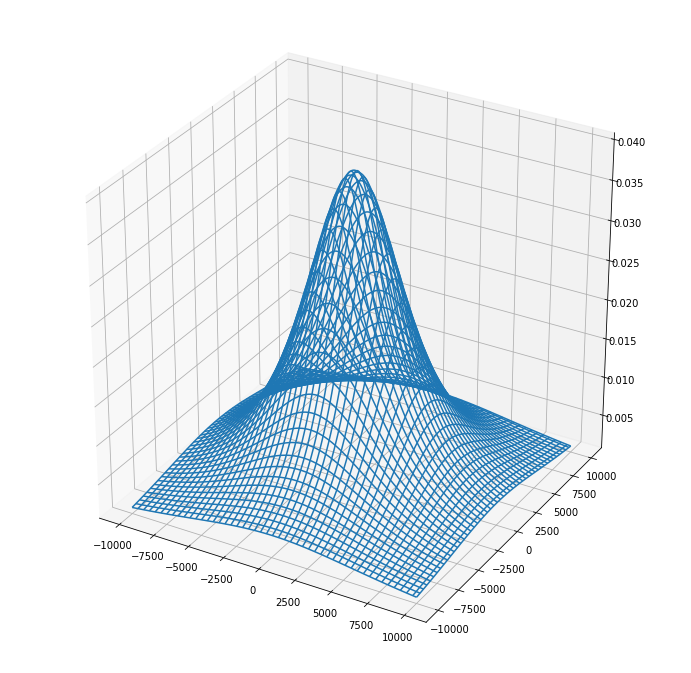

In [5]:
fig=plt.figure();
fig.set_size_inches(12,12);
ax = fig.add_subplot(111, projection='3d');

ax.plot_wireframe(x_input,y_input,mogi_results);

Plot deformation using a 2d color plot

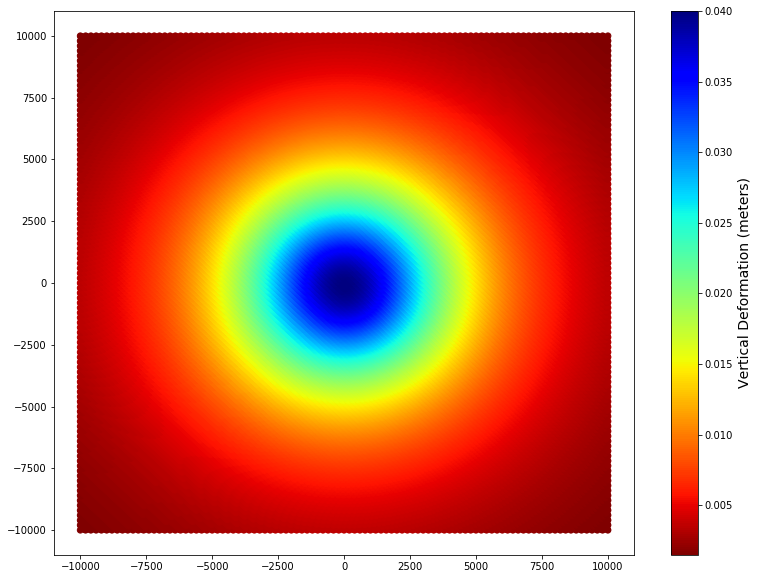

In [6]:
plt.gcf().set_size_inches(13,10);
plt.scatter(x_input.ravel()[::10],y_input.ravel()[::10],c=mogi_results.ravel()[::10],cmap='jet_r');
cb = plt.colorbar();
cb.set_label('Vertical Deformation (meters)',fontsize=14);

Function to generate phase difference from deformation measurements

In [7]:
def generatePhase(displacements, wavelength):
    return ((4*np.pi*displacements / wavelength) % (2*np.pi)) - np.pi

Generate phase differences from mogi deformation

In [8]:
wavelength = 3/100
phase = generatePhase(mogi_results,wavelength)

Plot Interferogram

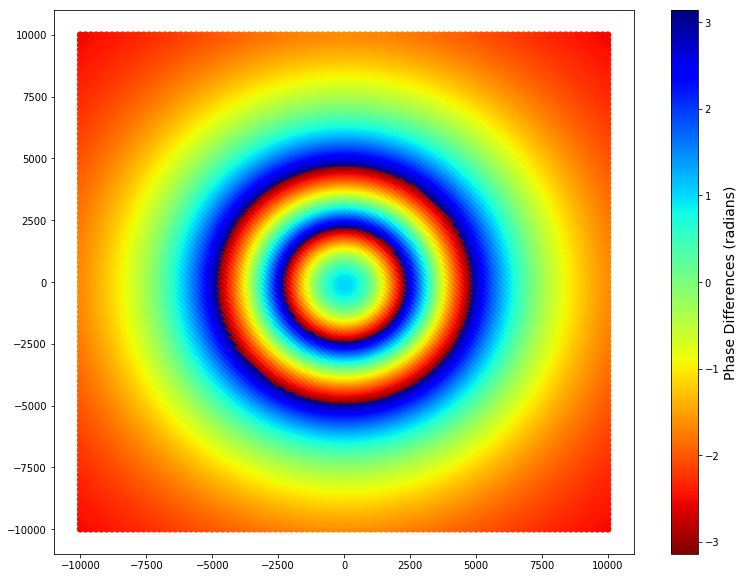

In [9]:
plt.gcf().set_size_inches(13,10);

plt.scatter(x_input.ravel()[::10],y_input.ravel()[::10],c=phase.ravel()[::10],cmap='jet_r');
cb = plt.colorbar();
cb.set_label("Phase Differences (radians)",fontsize=14)


Unwrap phase and convert to deformations

In [10]:
unwrapped = unwrap_phase(phase)
scaled_unwrapped = (wavelength / (4*np.pi)) * unwrapped

Plot reconstructed (relative) deformations

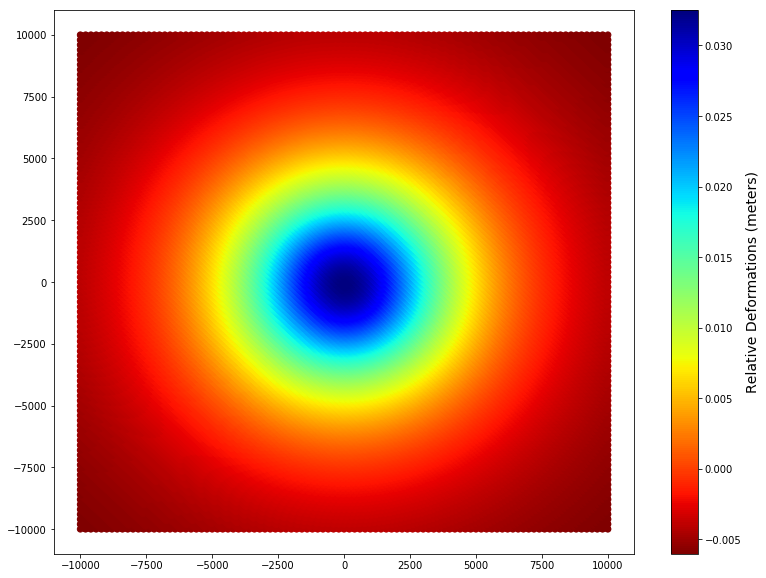

In [11]:
plt.gcf().set_size_inches(13,10);
plt.scatter(x_input.ravel()[::10], y_input.ravel()[::10],
            c=scaled_unwrapped.ravel()[::10],
            cmap='jet_r');
cb = plt.colorbar();
cb.set_label('Relative Deformations (meters)', fontsize=14)